In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

from sklearn.datasets.samples_generator import make_circles
X1, y1 = make_circles(100, factor=.1, noise=.1)


def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*



## Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.


## Motivating SVM

Consider the simple case of a classification task, in which the two classes of points are well separated.
We have 
* two continuous inputs
* two classes

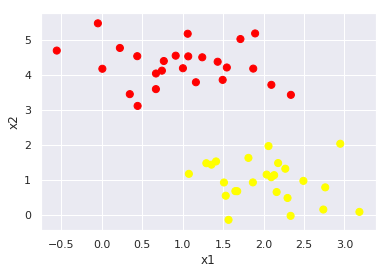

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');
plt.xlabel("x1")
plt.ylabel("x2");

## Logistic regression

In [22]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs',  fit_intercept=True)
clf.fit(X,y)
print(clf.coef_,clf.intercept_)

[[ 0.57306256 -2.18013484]] [4.81393202]


## Logistic regression
In logistic regression we have a linear function that is squeezed in $[0,1]$ by the logistic function.

The linear function is
$$
0.573 x_1 -2.18 x_2+ 4.81
$$
or, equivalently, the line
$$
x_2 =\frac{0.573}{2.18}x_1+\frac{4.81}{2.18}
$$

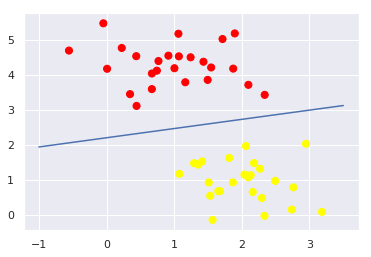

In [23]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot(xfit, 0.573/2.18 * xfit + 4.81/2.18, '-b')

## Logistic Regression
Probability of class $1$ is

$$
\phi(0.573 x_1 -2.18 x_2+ 4.81)=\frac{1}{1+e^{-(0.573 x_1 -2.18 x_2+ 4.81)}}
$$

and note that, when $0.573 x_1 -2.18 x_2+ 4.81\geq0$ then 

$$
\phi(0.573 x_1 -2.18 x_2+ 4.81)\geq 0.5
$$

and so all points $(x_1,x_2)$ such that $ 0.573 x_1 -2.18 x_2+ 4.81\geq0 $ are classified 
as *class 1*.

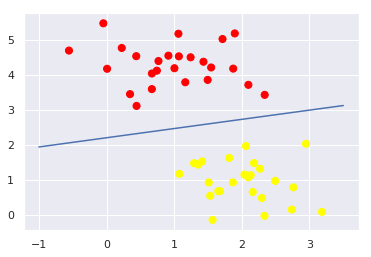

In [38]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot(xfit, 0.573/2.18 * xfit + 4.81/2.18, '-b')

**Logistic regression** is a  **linear discriminative** classifier, because it attempts to draw a straight line separating the two sets of data, and thereby create a model for classification.

For two dimensional data like that shown here, this is a task we could do by hand.

But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

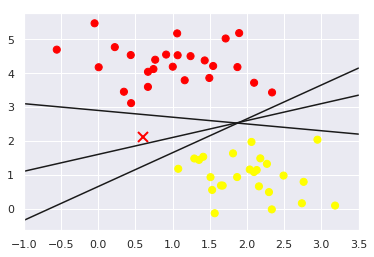

In [25]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

**Logistic regression** finds an optimal line: the line that maximises the likelihood function, that is the line that
guarantees that
$$
\phi(w_1 x_1 +w_2 x_2+ b)
$$
is a *calibrated* probability.

However, we can find an alternative solution by thinking geometrically instead of probabistically.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

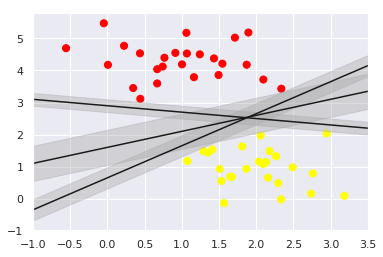

In [26]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)
plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use SKLearn SVM on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [27]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y);

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

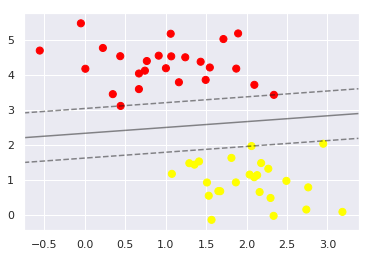

In [28]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Sklearn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

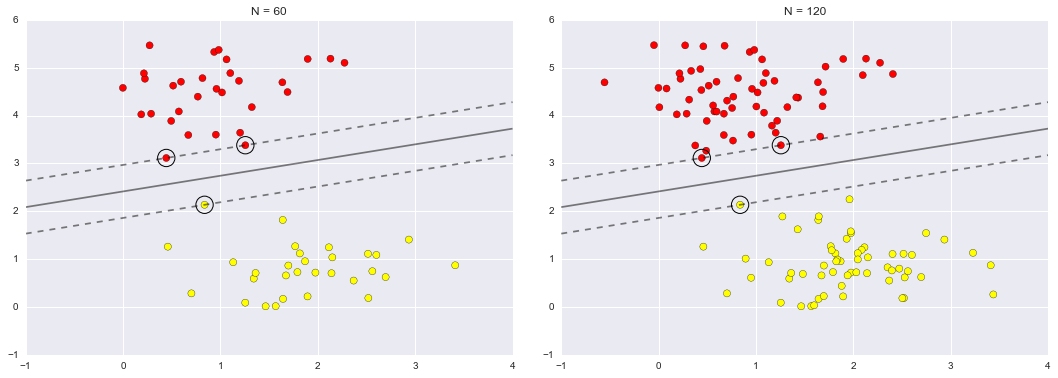

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

In [31]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 30, 50, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 30, 50, 200), value=10), Output()), _dom_classes=…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when  we allow the separator to be a nonlinear function.


To motivate nonlinear separators, let's look at some data that is not linearly separable:

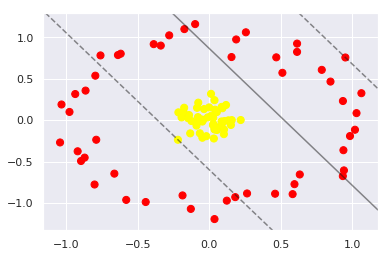

In [33]:
clf = SVC(kernel='linear').fit(X1, y1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.

## Can we separate them in some way
We notice that the points that are close to the origin are yellow and the points that
are further from the origin are red.

So maybe we can first transform the points 
* from Cartesian to Polar coordinates;
* separate them using a linear separator.

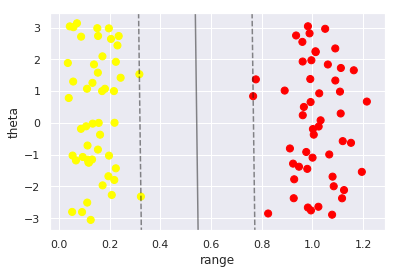

In [54]:
import math
def polar(x,y):
    return math.hypot(x,y),math.atan2(y,x)
PolarCoord = np.array([polar(X1[i,0],X1[i,1]) for i in range(X1.shape[0])])

clf = SVC(kernel='linear', C=1E10).fit(PolarCoord, y1)
plt.scatter(PolarCoord[:, 0], PolarCoord[:, 1], c=y1, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);
plt.xlabel("range")
plt.ylabel("theta");

## Nonlinear transformation
The above transformation (Cartesian to Polar) works well for the previous dataset, but there are other datasets
where we will need to find another nonlinear transformation.

1. Can we learn the nonlinear transformation from data?

Yes we can do it using a generic nonlinear function estimator,  a *kernel*.

In [34]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X1, y1);

/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


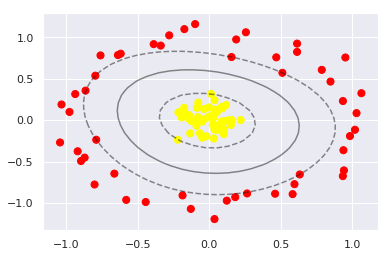

In [37]:
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn')
plot_svc_decision_function(clf)

Using this RBF (radial basis function) Kernel, we learn a suitable nonlinear decision boundary.

## RBF kernel

$$
K(x,x')=e^{-\frac{||x−x'||^2}{\gamma^2}}
$$

where $||x−x'||^2$ is the squared Euclidean distance between two data points x and x'.
Here $\gamma$ is a parameter that we need to select via cross-validation.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

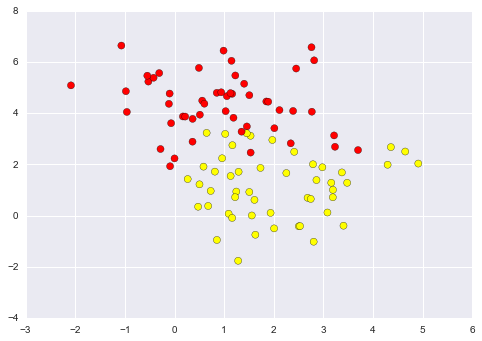

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

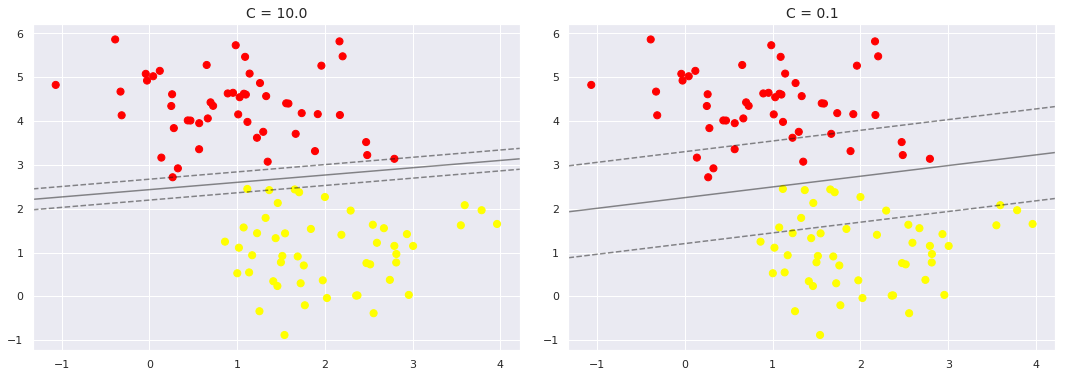

In [55]:
X, y = make_blobs(n_samples=100, centers=2,random_state=0, cluster_std=0.8)
fig, ax = plt.subplots(1, 2, figsize=(16, 6)) fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Sklearn:

In [56]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

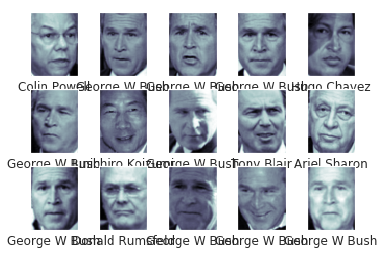

In [59]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.

We will split the data into a training and testing set:

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, 
                                                random_state=42)
X_train = X_train/255
X_test  = X_test /255

In [85]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',  C=1)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.362962962962963


array([[ 0,  0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 51,  0,  0,  0,  0],
       [ 0,  0,  0, 25,  0,  0,  0,  0],
       [ 0,  0,  0, 98,  0,  0,  0,  0],
       [ 0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0, 15,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0,  0,  0]])

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [91]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc, param_grid, cv=2)

%time grid.fit(X_train, y_train)


/home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 3min 25s, sys: 35 ms, total: 3min 25s
Wall time: 3min 25s
GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [92]:
print(grid.best_params_)

{'C': 50, 'gamma': 0.001}


In [101]:
print(grid.cv_results_)

{'mean_fit_time': array([2.16223033, 2.16889326, 2.45515792, 2.12443376, 2.21432932,
       2.24635474, 1.989079  , 2.16591064, 2.11958273, 1.89769634,
       1.75169261, 2.06177227, 1.91214895, 1.58747371, 1.63247681,
       2.0651447 ]), 'std_fit_time': array([0.02281354, 0.08293255, 0.22956281, 0.0476818 , 0.0451546 ,
       0.08478682, 0.01164929, 0.02963246, 0.02382964, 0.01791129,
       0.0462976 , 0.01154585, 0.03219584, 0.02640981, 0.01453898,
       0.02785269]), 'mean_score_time': array([0.72768442, 0.78404156, 0.78780413, 0.74199804, 0.75080117,
       0.81614002, 0.74758625, 0.75499209, 0.73547387, 0.71988742,
       0.69946027, 0.71287886, 0.71580267, 0.65796518, 0.663469  ,
       0.70903548]), 'std_score_time': array([0.00428742, 0.05352861, 0.00545115, 0.01150738, 0.01471284,
       0.05546224, 0.02885837, 0.03505981, 0.0042977 , 0.00270307,
       0.00648698, 0.00974356, 0.00688901, 0.00134331, 0.01660478,
       0.00559164]), 'param_C': masked_array(data=[1, 1, 1, 1,

svc = SVC(kernel='rbf',  C=50, gamma=0.001)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)

In [94]:
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.8333333333333334


array([[ 8,  0,  3,  0,  1,  0,  0,  0],
       [ 2, 42,  1,  5,  1,  0,  0,  0],
       [ 0,  2, 19,  3,  0,  0,  0,  1],
       [ 0,  3,  2, 87,  3,  1,  0,  2],
       [ 1,  0,  1,  0, 17,  0,  1,  1],
       [ 1,  1,  0,  0,  2, 10,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  1,  4,  1,  0,  0, 32]])

Now we got 80%. We can do it better by doing a finer grid search around the best parameters. 